# 转置卷积

In [18]:
import torch
from torch import nn
from d2l import torch as d2l

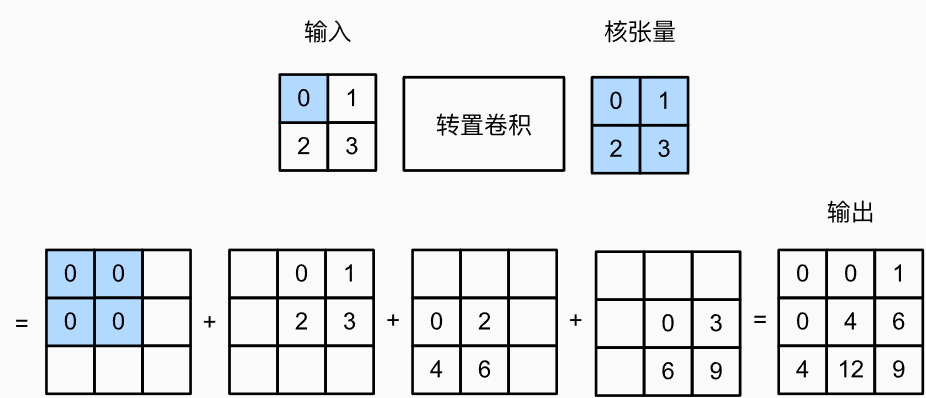

In [19]:
def trans_conv(X, K):
    """
    执行转置卷积操作。

    参数:
    X (torch.Tensor): 输入张量，代表输入数据，形状为 (N, H, W)，其中 N 为批次大小,H 和 W 为高度和宽度。
    K (torch.Tensor): 卷积核张量，形状为 (h, w)，其中 h 和 w 为卷积核的高度和宽度。

    返回:
    torch.Tensor: 输出张量，包含转置卷积的结果，形状为 (N, H + h - 1, W + w - 1)。
    """
    # 获取卷积核 K 的形状
    h, w = K.shape
    
    # 创建一个输出张量 Y
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    
    # 遍历输入张量 X 的所有元素
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # 将输入张量 X 的元素与卷积核 K 相乘，并将结果累加到输出张量 Y 的适当位置
            Y[i: i + h, j: j + w] += X[i, j] * K
    
    # 返回输出张量 Y，它包含了转置卷积的结果
    return Y


In [20]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

In [21]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)

## 填充、步幅和多通道
与常规卷积不同，在转置卷积中，填充被应用于的输出（常规卷积将填充应用于输入）。 例如，当将高和宽两侧的填充数指定为1时，转置卷积的输出中将删除第一和最后的行与列。

In [22]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[4.]]]], grad_fn=<ConvolutionBackward0>)

在转置卷积中，步幅被指定为中间结果（输出），而不是输入。

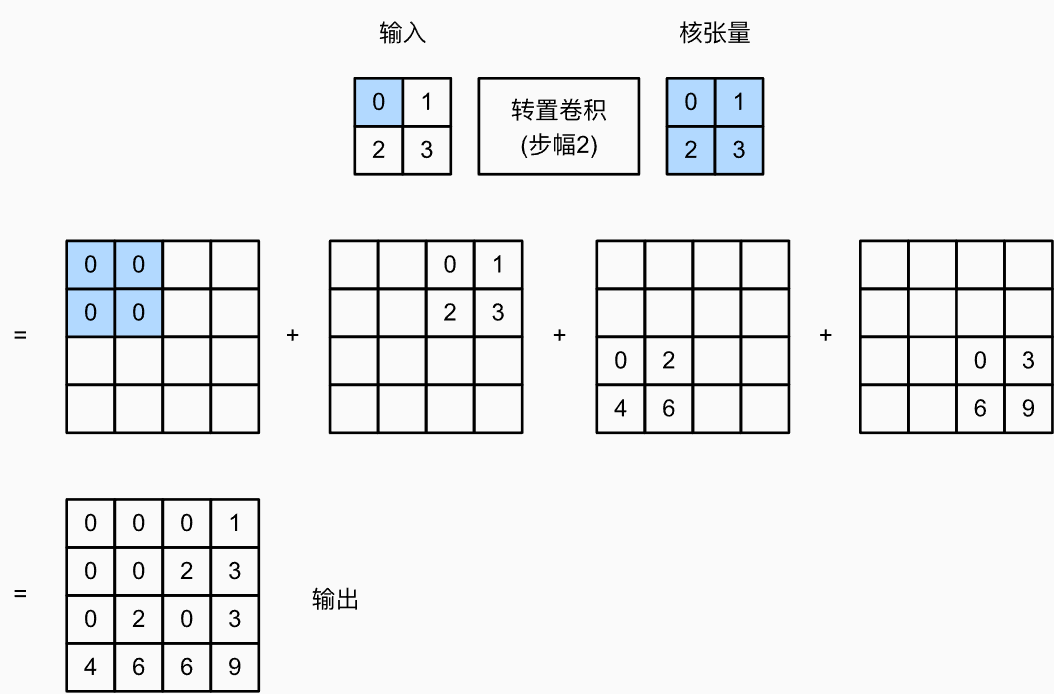

In [23]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<ConvolutionBackward0>)

In [24]:
X = torch.rand(size=(1, 10, 16, 16))
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)
tconv(conv(X)).shape == X.shape

True

## 与矩阵变换的联系

In [25]:
X = torch.arange(9.0).reshape(3, 3)
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
Y = d2l.corr2d(X, K)
X, K, Y

(tensor([[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]]),
 tensor([[1., 2.],
         [3., 4.]]),
 tensor([[27., 37.],
         [57., 67.]]))

In [26]:
def kernel2matrix(K):
    k, W = torch.zeros(5), torch.zeros((4, 9))
    k[:2], k[3:5] = K[0, :], K[1, :]
    W[0, :5], W[1, 1:6], W[2, 3:8], W[3, 4:] = k, k, k, k
    return W

W = kernel2matrix(K)
W

tensor([[1., 2., 0., 3., 4., 0., 0., 0., 0.],
        [0., 1., 2., 0., 3., 4., 0., 0., 0.],
        [0., 0., 0., 1., 2., 0., 3., 4., 0.],
        [0., 0., 0., 0., 1., 2., 0., 3., 4.]])

In [27]:
Y == torch.matmul(W, X.reshape(-1)).reshape(2, 2)

tensor([[True, True],
        [True, True]])

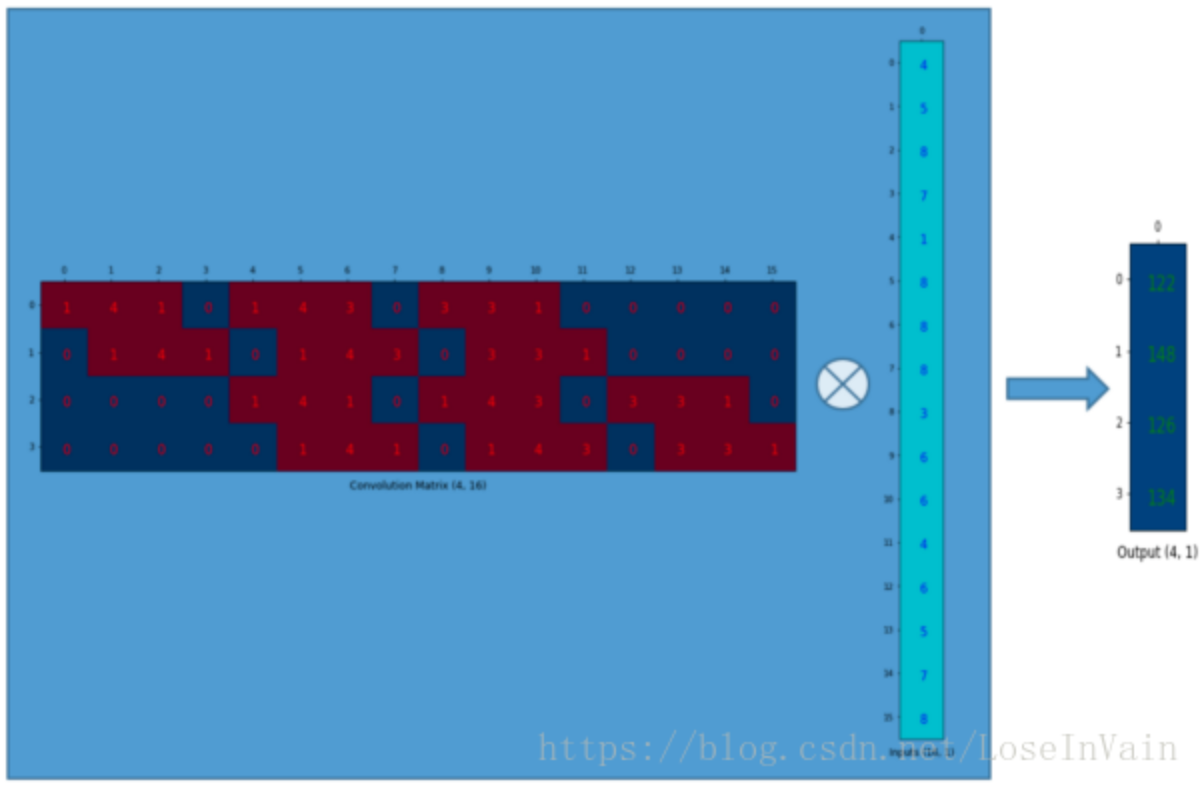

In [28]:
Z = trans_conv(Y, K)
Z == torch.matmul(W.T, Y.reshape(-1)).reshape(3, 3)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

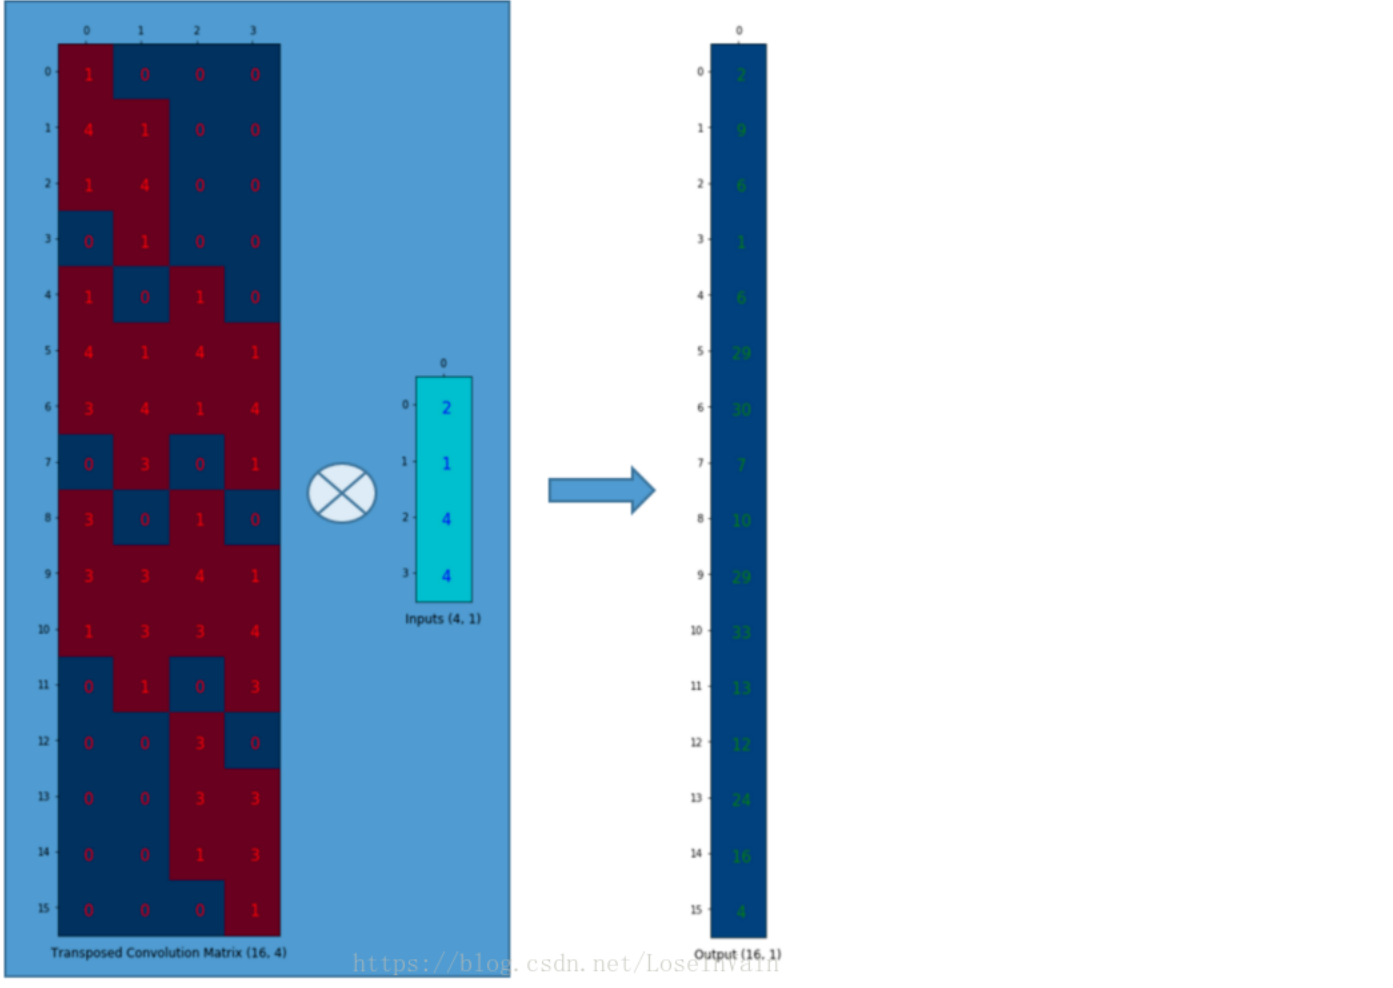